In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv") # Loaded training data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Clearly gender played a role in deciding who survived the Titanic disaster. This makes sense because women and children are always first to be put on a lifeboat. Now the other factors could be the ticket class which signifies Socio-Economic status and a lesser intuitive one, whether they had other family members on board. We shall analyze the data to confirm these intuitions.

In [4]:
gender_rate = train_data[["Sex","Survived"]].groupby(['Sex'], as_index = False).mean()
print(gender_rate)

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [5]:
pclass_dependence = train_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index = False).mean()
print(pclass_dependence)

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [6]:
SibSp_dependence =  train_data[["SibSp", "Survived"]].groupby(['SibSp'], as_index = False).mean()
print(SibSp_dependence)

   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


In [7]:
ParCh_dependence =  train_data[["Parch", "Survived"]].groupby(['Parch'], as_index = False).mean()
print(ParCh_dependence)

   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000


Hence confirmed direct dependence parameters:
    1. Sex
    2. Ticket Class
    3. Number of siblings/Spouses
There doesn't seem to be a direct dependence of the number of Parents/Children parameter.

Age could be a factor but as its a numerical value unlike the previous ones which were categorical, we will have to visualize it to analyze it. Intuition: Ages could be affected band wise, For eg its more likely for infants and the elderly to be alive as they would get special attention.

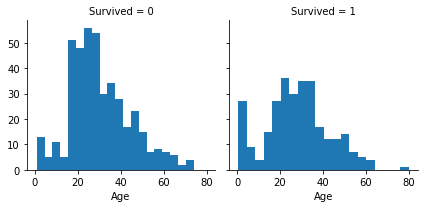

In [8]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

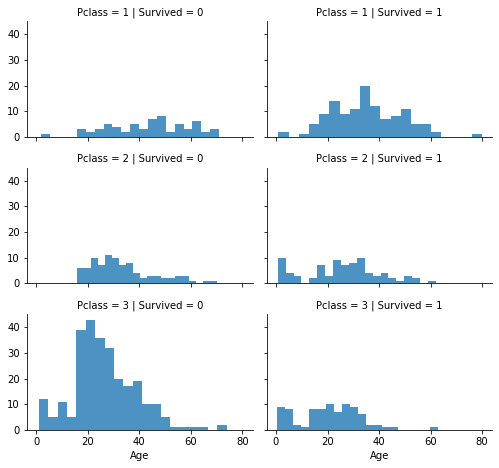

In [9]:
g1 = sns.FacetGrid(train_data, col = 'Survived', row = 'Pclass', height = 2.2, aspect = 1.6)
g1.map(plt.hist, 'Age', alpha = 0.8, bins = 20) 

**Arguments of FacetGrid**

FacetGrid is used to visualize combined features. We want to see Ticket-class-wise how many survived or not in each age group. So our numbers change over whether one survived or not, hence that's the column. We want to see these numbers Ticket class wise and hence Pclass is the row argument. There would be no problem in changing the rows and columns in this case as both would complete the purpose of intuition. Height changes the height of the plot. And aspect decide the height over width of the plot ratio.

**Arguments of map**
    1. plt.hist signifies the type of the plot i.e. histogram
    2. Second argument is the value being plotted on the x-axis while the y-axis gives the count
    3. Alpha is colour related, more the alpha the darker it is. Lies between 0 and 1.
    4. Bins defines the number of columns in a unit length. Hence more the number of bins, thinner the bars in the histogram plot.
    

Now as it seems that where the passenger embarked from could be a factor, let us analyze that too. We will have to separately do this for males and females. We do not bring age into this as the correlation between age and PClass has already been established. We are now trying to correlate the rest.


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:733: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


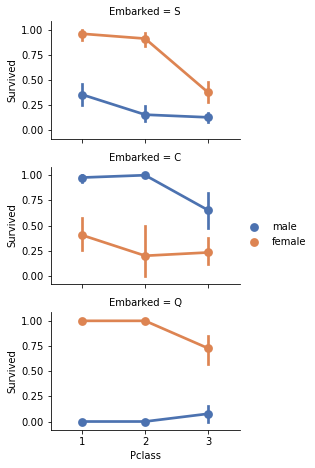

In [10]:
g2 = sns.FacetGrid(train_data, row = 'Embarked', height = 2.2, aspect = 1.6)
g2.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep')
g2.add_legend()

#  **So the steps we have covered till now**
    1. Finding factors of dependence, i.e. which clearly affect the outcome of survivability of a passenger.
    2. Find correlations between these factors. First we found it between Age, Pclass and Survival. Then Embark location, Pclass, Sex and Survival. Clearly we have established that indeed these are correlated.
    3. The numerical values from Fare is still left. And Fare evidently signfies the Pclass of a passenger. Hence we need to find this correlation too. We will band the Fare just like we did it for age.
    

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


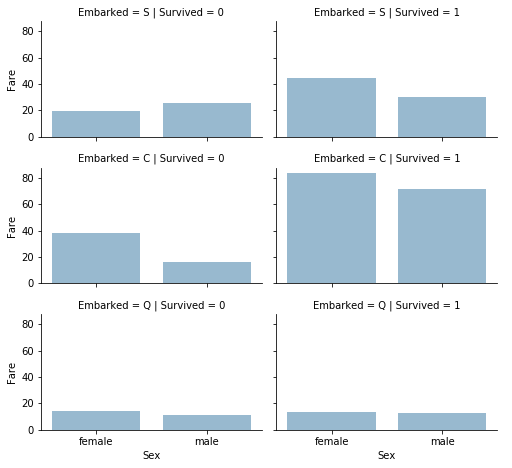

In [11]:
g3 = sns.FacetGrid(train_data, row = 'Embarked', col = 'Survived', height = 2.2, aspect = 1.6)
g3.map(sns.barplot, 'Sex', 'Fare', alpha = 0.5, ci = None)
g3.add_legend()

We are done with finding correlations. Now we edit out unnecessary data and combine certain parameters.

In [12]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
# Cabin number and ticket number have too many discrepancies i.e. missing and redundant data. Also there is no intuitive conclusion from these.
# Hence we drop these features. To maintain consistency we will drop them from both the training and test set.
# Also as SEC(Socio-Economic Class) is already signified by the Pclass we'll not be analyzing titles as part of the passenger names
train_data = train_data.drop(['Ticket','Cabin'], axis = 1)
test_data = test_data.drop(['Ticket','Cabin'], axis = 1)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


We are almost ready to run our ML model but that can be done on only numerical values. Hence we need to convert all our categorical data into numerical values.

In [14]:
# converting Sex into numerical values
combine = [train_data, test_data]
for dataset in combine:
     # changing male/female to 0/1 respectively, map takes dictionary as its parameter
    dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1}).astype(int)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S


Now all missing values need to be completed i.e. in Age column there are some missing values. We need to fill them up with values predicted from trends in the rest of the data. More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

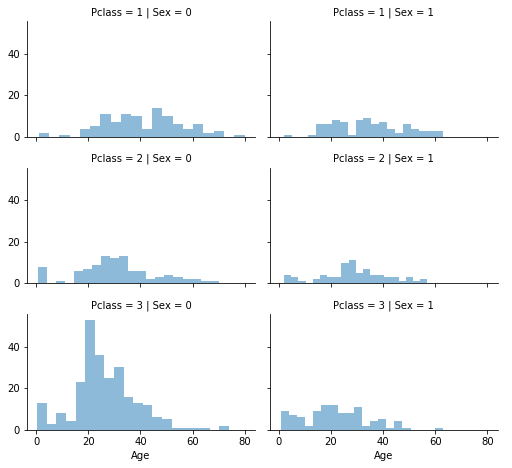

In [15]:
grid = sns.FacetGrid(train_data, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations. Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [16]:
guess_ages = np.zeros((2, 3))
# make the array that will store the predicted values for each value of Sex and Pclass

In [17]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            # select those rows with the certain value of Sex, Pclass. Then select only the Age column with the null values dropped
            age_guess = guess_df.median()
            # get the median value from all the data
            guess_ages[i, j] = int(age_guess/0.5 + 0.5) * 0.5
            # Convert random age float to nearest .5 age
    # Now that we have made the guess matrix, we need to put the appropriate values from the matrix into the column of age wherever the values are missing.
    
    for i in range(0, 2):
        for j in range(0, 3):
            # Finding the location of missing values and putting in the calculated average
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),'Age'] = guess_ages[i,j]
    dataset['Age'] = dataset['Age'].astype(int)
    
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,S


Now that we have all the values, we can start towards preparing our data for applying our machine learning model. As the model would take only numerical values we need to change all columns into integers. But first we cant analyze with so many different discrete data for ages, hence we will categorize them into age bands.


In [18]:
train_data['AgeBand'] = pd.cut(train_data['Age'], 5)
train_data[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index = False).mean().sort_values(by = 'AgeBand')
# Cut the total range of age into 5 bands
# We want the columns AgeBand and corresponding survival which has been grouped by the AgeBand and it isn't the index

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Now based on these bands we will simply assign numeric values to the bands.

In [19]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[ (dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ (dataset['Age'] > 64), 'Age']

We can now remove the AgeBand feature.

In [20]:
train_data = train_data.drop(['AgeBand'], axis = 1)
combine = [train_data, test_data]
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,8.0500,S


# **Create new feature combining existing features**
We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.

In [21]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
train_data[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index = False).mean().sort_values(by='Survived', ascending = False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Now that we have a feature called family Size, we will be dropping SibSp and Parch

In [22]:
train_data = train_data.drop(['Parch', 'SibSp'], axis=1)
test_data = test_data.drop(['Parch', 'SibSp'], axis=1)
combine = [train_data, test_data]

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",0,1,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",1,1,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",0,2,8.0500,S,1


Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance. We also change our categorical values to numeric.

In [23]:
freq_port = train_data.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",0,1,7.2500,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,71.2833,1,2
2,3,1,3,"Heikkinen, Miss. Laina",1,1,7.9250,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,53.1000,0,2
4,5,0,3,"Allen, Mr. William Henry",0,2,8.0500,0,1


For Fare we will be manipulating it exactly as done for the Age feature.

In [24]:
test_data['Fare'].fillna(test_data['Fare'].dropna().median(), inplace=True)
# We will now create the FareBand

train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
train_data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)


,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [25]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_data = train_data.drop(['FareBand'], axis=1)
combine = [train_data, test_data]
    
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",0,1,0,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,3,1,2
2,3,1,3,"Heikkinen, Miss. Laina",1,1,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,3,0,2
4,5,0,3,"Allen, Mr. William Henry",0,2,1,0,1
5,6,0,3,"Moran, Mr. James",0,1,1,2,1
6,7,0,1,"McCarthy, Mr. Timothy J",0,3,3,0,1
7,8,0,3,"Palsson, Master. Gosta Leonard",0,0,2,0,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,1,1,0,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,0,2,1,2


The above information didn't give a converge for neither Logistic Regression nor SVM's. Hence we need more features.

In [26]:
# Firstly we'll change FamilySize to IsAlone, whether the passenger is travelling alone or not
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# We can now drop FamilySize
train_data = train_data.drop(['FamilySize'], axis=1)
test_data = test_data.drop(['FamilySize'], axis=1)
combine = [train_data, test_data]

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",0,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,3,1,0
2,3,1,3,"Heikkinen, Miss. Laina",1,1,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,3,0,0
4,5,0,3,"Allen, Mr. William Henry",0,2,1,0,1


In [27]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

Till this step we didn't get convergence in Logistic Regression or SVM. Both asked for one more column entry. So another feature that could be used is the Title of people in their names. We need to extract them and classify them into Rare ones like Countess, Capt. and the common ones like Mr. 
Rare ones will usually belong to higher SEC.

In [28]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_data['Title'], train_data['Sex'])

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_data.head()

train_data = train_data.drop(['Name', 'PassengerId'], axis=1)
test_data = test_data.drop(['Name'], axis=1)
combine = [train_data, test_data]

In [29]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1).copy()

# Logistic Regression



In [30]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

# SVM

In [31]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

78.23

# KNN

In [32]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.74

# Decision Tree

In [33]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

# Random Forest

In [34]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.76

In [35]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': Y_pred})
output.to_csv('my_submission.csv', index=False)